# Initial Setup and Library Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import joblib
from joblib import Parallel, delayed

import os

import warnings
warnings.filterwarnings('ignore')

/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


# Data Loading and Preparation

In [2]:
df_train = pd.read_csv('dataset/exoTrain.csv')
df_test = pd.read_csv('dataset/exoTest.csv')

df = pd.concat([df_train, df_test], ignore_index=True)

In [3]:
df_train = pd.read_csv('dataset/exoTrain.csv')
df_test = pd.read_csv('dataset/exoTest.csv')
df = pd.concat([df_train, df_test], ignore_index=True)

X = df.drop('LABEL', axis=1)
y = df['LABEL']
y_prepared = (y - 1).values

X_prepared = X.values
X_prepared = np.expand_dims(X_prepared, axis=1)

print("--- Data Loading and Preparation Complete ---")
print(f"Total number of samples: {len(df)}")
print(f"Shape of the feature data (X): {X_prepared.shape}")
print(f"Shape of the label data (y): {y_prepared.shape}")
print(f"Type of y_prepared: {type(y_prepared)}")

--- Data Loading and Preparation Complete ---
Total number of samples: 5657
Shape of the feature data (X): (5657, 1, 3197)
Shape of the label data (y): (5657,)
Type of y_prepared: <class 'numpy.ndarray'>


# Exploratory Data Analysis: Target Variable Distribution

--- Target Variable Distribution ---
Counts:
LABEL
1    5615
2      42
Name: count, dtype: int64

Percentages:
LABEL
1    99.257557
2     0.742443
Name: proportion, dtype: float64


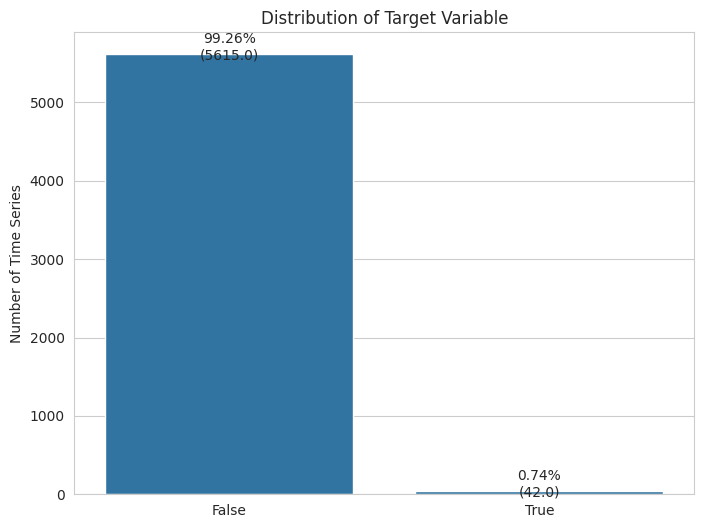

In [4]:
target_counts = y.value_counts()
target_percentages = y.value_counts(normalize=True) * 100

print("--- Target Variable Distribution ---")
print("Counts:")
print(target_counts)
print("\nPercentages:")
print(target_percentages)

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=y_prepared)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(y_prepared):.2f}%\n({p.get_height()})'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Target Variable')
plt.ylabel('Number of Time Series')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

# Importing Deep Learning Libraries and Modules

In [5]:
import sklearn
import numpy as np
import pandas as pd
import torch
from torch import nn
from models import TimerBackbone

from torch.amp import GradScaler, autocast 

import json
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

import joblib
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader, Sampler 
from scipy.stats import entropy as spectral_entropy
import pyentrp

import random

from sklearn.model_selection import StratifiedKFold
import gc 

2025-10-05 09:52:32.776338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759639952.819082   28602 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759639952.832613   28602 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759639952.917077   28602 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759639952.917154   28602 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759639952.917157   28602 computation_placer.cc:177] computation placer alr

# Dataset preparation

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y_prepared, test_size=0.1, random_state=42, stratify=y_prepared
)

In [7]:
class ExoDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Model Architecture

In [ ]:
class Model(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.task_name = configs.task_name
        self.backbone = TimerBackbone.Model(configs)

        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(configs.d_model, 1)
        )

    def classification(self, x_enc):
        B, M, L = x_enc.shape

        means = x_enc.mean(2, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=2, keepdim=True, unbiased=False) + 1e-5).detach()
        x_enc /= stdev

        enc_out, n_vars = self.backbone.patch_embedding(x_enc)
        enc_out, attns = self.backbone.decoder(enc_out)
        
        output = enc_out.reshape(B, M, -1, self.backbone.d_model)
        output = output.mean(dim=1)
        output = output.permute(0, 2, 1)

        output = self.classification_head(output)

        return output

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, mask=None):
        if self.task_name == 'classification':
            dec_out = self.classification(x_enc)
            return dec_out

        raise NotImplementedError

# Training

In [9]:
def train_fold(fold_num, X_train_fold, y_train_fold, X_val_fold, y_val_fold, config):
    print(f"\n{'='*25} FOLD {fold_num+1} {'='*25}")
    
    class Configs:
        def __init__(self, config_dict):
            for key, value in config_dict.items():
                setattr(self, key, value)

    configs = Configs(config)
    
    model = Model(configs).cuda()
    train_dataset = ExoDataset(X_train_fold, y_train_fold)
    val_dataset = ExoDataset(X_val_fold, y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'], pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], pin_memory=True)
    
    print(f"Data for fold {fold_num+1} loaded: {len(train_dataset)} train, {len(val_dataset)} val samples.")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=config['epoch'], eta_min=1e-6)
    
    counts = pd.Series(y_train_fold).value_counts()
    pos_weight_value = counts.get(0, 1) / counts.get(1, 1)
    pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32).cuda()
    loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    
    scaler = GradScaler()
    
    best_model_path = f"{config['save_ckpt_path']}/best_model_fold_{fold_num+1}.pth"
    best_val_auc = -1
    patience = 5
    patience_counter = 0

    for epoch in range(config['epoch']):
        model.train()
        total_loss = 0
        all_preds, all_targets = [], []
        current_lr = optimizer.param_groups[0]['lr']
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["epoch"]} (LR: {current_lr:.6f})')

        for batch in progress_bar:
            input_x, gt = batch
            input_x = input_x.cuda()
            gt = gt.cuda().float().unsqueeze(1)

            with autocast("cuda"):
                output = model(input_x)
                loss = loss_function(output, gt)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            all_preds.extend(torch.sigmoid(output).cpu().detach().numpy())
            all_targets.extend(gt.cpu().detach().numpy())
            progress_bar.set_postfix(loss=loss.item())

        scheduler.step()
        train_auc = roc_auc_score(all_targets, all_preds)
        
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_x, gt = batch
                input_x = input_x.cuda()
                gt = gt.cuda().float().unsqueeze(1)
                with autocast("cuda"):
                    output = model(input_x)
                val_preds.extend(torch.sigmoid(output).cpu().numpy())
                val_targets.extend(gt.cpu().numpy())

        val_auc = roc_auc_score(val_targets, val_preds)
        print(f"\nEpoch {epoch+1} Summary: Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        if val_auc > best_val_auc:
            print(f"--> Val AUC improved from {best_val_auc:.4f} to {val_auc:.4f}. Saving model...")
            best_val_auc = val_auc
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"--> No improvement. Patience: {patience_counter}/{patience}. Best AUC: {best_val_auc:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
            
    del model, train_loader, val_loader, train_dataset, val_dataset
    gc.collect()
    torch.cuda.empty_cache()

    return best_val_auc

def run_training_cv(X_data, y_data, config):
    if not os.path.exists(config['save_ckpt_path']):
        os.makedirs(config['save_ckpt_path'])

    N_SPLITS = 5
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    oof_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data)):
        
        # Split the data using the indices from StratifiedKFold
        X_train_fold, X_val_fold = X_data[train_idx], X_data[val_idx]
        y_train_fold, y_val_fold = y_data[train_idx], y_data[val_idx]
        
        best_fold_auc = train_fold(
            fold_num=fold,
            X_train_fold=X_train_fold, y_train_fold=y_train_fold,
            X_val_fold=X_val_fold, y_val_fold=y_val_fold,
            config=config
        )
        oof_scores.append(best_fold_auc)

    print(f"\n{'='*25} CROSS-VALIDATION FINISHED {'='*25}")
    print(f"Scores for each fold: {[f'{score:.4f}' for score in oof_scores]}")
    print(f"Mean CV AUC: {np.mean(oof_scores):.4f}")
    print(f"Std Dev CV AUC: {np.std(oof_scores):.4f}")

In [10]:
with open('config.json', 'r') as f:
    config = json.load(f)

run_training_cv(X_train, y_train, config=config)


========================= FOLD 1 =========================
Data for fold 1 loaded: 4072 train, 1019 val samples.


Epoch 1/20 (LR: 0.000100): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:23<00:00,  5.88it/s, loss=1.05]



Epoch 1 Summary: Train AUC: 0.4665 | Val AUC: 0.5000
--> Val AUC improved from -1.0000 to 0.5000. Saving model...


Epoch 2/20 (LR: 0.000099): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:21<00:00,  6.41it/s, loss=1.31]



Epoch 2 Summary: Train AUC: 0.5252 | Val AUC: 0.5079
--> Val AUC improved from 0.5000 to 0.5079. Saving model...


Epoch 3/20 (LR: 0.000098): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:21<00:00,  6.41it/s, loss=4.11]



Epoch 3 Summary: Train AUC: 0.5135 | Val AUC: 0.5000
--> No improvement. Patience: 1/5. Best AUC: 0.5079


Epoch 4/20 (LR: 0.000095): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:19<00:00,  6.88it/s, loss=0.506]



Epoch 4 Summary: Train AUC: 0.4916 | Val AUC: 0.5000
--> No improvement. Patience: 2/5. Best AUC: 0.5079


Epoch 5/20 (LR: 0.000091): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:22<00:00,  6.11it/s, loss=5.84]



Epoch 5 Summary: Train AUC: 0.4844 | Val AUC: 0.5000
--> No improvement. Patience: 3/5. Best AUC: 0.5079


Epoch 6/20 (LR: 0.000086): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:22<00:00,  6.04it/s, loss=0.577]



Epoch 6 Summary: Train AUC: 0.4628 | Val AUC: 0.5000
--> No improvement. Patience: 4/5. Best AUC: 0.5079


Epoch 7/20 (LR: 0.000080): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:19<00:00,  6.91it/s, loss=1.13]



Epoch 7 Summary: Train AUC: 0.5309 | Val AUC: 0.5000
--> No improvement. Patience: 5/5. Best AUC: 0.5079
Early stopping triggered at epoch 7.

========================= FOLD 2 =========================
Data for fold 2 loaded: 4073 train, 1018 val samples.


Epoch 1/20 (LR: 0.000100): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:21<00:00,  6.42it/s, loss=0.497]



Epoch 1 Summary: Train AUC: 0.3846 | Val AUC: 0.5114
--> Val AUC improved from -1.0000 to 0.5114. Saving model...


Epoch 2/20 (LR: 0.000099): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:20<00:00,  6.48it/s, loss=0.571]



Epoch 2 Summary: Train AUC: 0.3899 | Val AUC: 0.5113
--> No improvement. Patience: 1/5. Best AUC: 0.5114


Epoch 3/20 (LR: 0.000098): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:20<00:00,  6.51it/s, loss=1.01]



Epoch 3 Summary: Train AUC: 0.4757 | Val AUC: 0.4020
--> No improvement. Patience: 2/5. Best AUC: 0.5114


Epoch 4/20 (LR: 0.000095): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:22<00:00,  6.06it/s, loss=0.983]



Epoch 4 Summary: Train AUC: 0.4860 | Val AUC: 0.5000
--> No improvement. Patience: 3/5. Best AUC: 0.5114


Epoch 5/20 (LR: 0.000091): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:21<00:00,  6.27it/s, loss=0.769]



Epoch 5 Summary: Train AUC: 0.5220 | Val AUC: 0.5000
--> No improvement. Patience: 4/5. Best AUC: 0.5114


Epoch 6/20 (LR: 0.000086): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:18<00:00,  7.25it/s, loss=0.761]



Epoch 6 Summary: Train AUC: 0.4512 | Val AUC: 0.5000
--> No improvement. Patience: 5/5. Best AUC: 0.5114
Early stopping triggered at epoch 6.

========================= FOLD 3 =========================
Data for fold 3 loaded: 4073 train, 1018 val samples.


Epoch 1/20 (LR: 0.000100): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:20<00:00,  6.56it/s, loss=4.1]



Epoch 1 Summary: Train AUC: 0.5526 | Val AUC: 0.5721
--> Val AUC improved from -1.0000 to 0.5721. Saving model...


Epoch 2/20 (LR: 0.000099): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:21<00:00,  6.18it/s, loss=0.972]



Epoch 2 Summary: Train AUC: 0.4647 | Val AUC: 0.5000
--> No improvement. Patience: 1/5. Best AUC: 0.5721


Epoch 3/20 (LR: 0.000098): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:20<00:00,  6.55it/s, loss=0.643]



Epoch 3 Summary: Train AUC: 0.5644 | Val AUC: 0.4110
--> No improvement. Patience: 2/5. Best AUC: 0.5721


Epoch 4/20 (LR: 0.000095): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:19<00:00,  7.02it/s, loss=0.682]



Epoch 4 Summary: Train AUC: 0.4364 | Val AUC: 0.5000
--> No improvement. Patience: 3/5. Best AUC: 0.5721


Epoch 5/20 (LR: 0.000091): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:22<00:00,  6.09it/s, loss=0.54]



Epoch 5 Summary: Train AUC: 0.4491 | Val AUC: 0.5000
--> No improvement. Patience: 4/5. Best AUC: 0.5721


Epoch 6/20 (LR: 0.000086): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:21<00:00,  6.32it/s, loss=0.67]



Epoch 6 Summary: Train AUC: 0.5033 | Val AUC: 0.5000
--> No improvement. Patience: 5/5. Best AUC: 0.5721
Early stopping triggered at epoch 6.

========================= FOLD 4 =========================
Data for fold 4 loaded: 4073 train, 1018 val samples.


Epoch 1/20 (LR: 0.000100): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:19<00:00,  7.02it/s, loss=0.691]



Epoch 1 Summary: Train AUC: 0.4358 | Val AUC: 0.5015
--> Val AUC improved from -1.0000 to 0.5015. Saving model...


Epoch 2/20 (LR: 0.000099): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:20<00:00,  6.57it/s, loss=0.83]



Epoch 2 Summary: Train AUC: 0.4962 | Val AUC: 0.5000
--> No improvement. Patience: 1/5. Best AUC: 0.5015


Epoch 3/20 (LR: 0.000098): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:20<00:00,  6.48it/s, loss=0.357]



Epoch 3 Summary: Train AUC: 0.4470 | Val AUC: 0.5000
--> No improvement. Patience: 2/5. Best AUC: 0.5015


Epoch 4/20 (LR: 0.000095): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:19<00:00,  6.92it/s, loss=0.598]



Epoch 4 Summary: Train AUC: 0.3837 | Val AUC: 0.5000
--> No improvement. Patience: 3/5. Best AUC: 0.5015


Epoch 5/20 (LR: 0.000091): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:21<00:00,  6.35it/s, loss=4.37]



Epoch 5 Summary: Train AUC: 0.4419 | Val AUC: 0.5000
--> No improvement. Patience: 4/5. Best AUC: 0.5015


Epoch 6/20 (LR: 0.000086): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:22<00:00,  6.15it/s, loss=0.933]



Epoch 6 Summary: Train AUC: 0.3996 | Val AUC: 0.4792
--> No improvement. Patience: 5/5. Best AUC: 0.5015
Early stopping triggered at epoch 6.

========================= FOLD 5 =========================
Data for fold 5 loaded: 4073 train, 1018 val samples.


Epoch 1/20 (LR: 0.000100): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:20<00:00,  6.65it/s, loss=1.05]



Epoch 1 Summary: Train AUC: 0.4715 | Val AUC: 0.5000
--> Val AUC improved from -1.0000 to 0.5000. Saving model...


Epoch 2/20 (LR: 0.000099): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:19<00:00,  7.10it/s, loss=1.16]



Epoch 2 Summary: Train AUC: 0.4932 | Val AUC: 0.4886
--> No improvement. Patience: 1/5. Best AUC: 0.5000


Epoch 3/20 (LR: 0.000098): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:20<00:00,  6.50it/s, loss=0.433]



Epoch 3 Summary: Train AUC: 0.3984 | Val AUC: 0.5000
--> No improvement. Patience: 2/5. Best AUC: 0.5000


Epoch 4/20 (LR: 0.000095): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:22<00:00,  6.06it/s, loss=0.65]



Epoch 4 Summary: Train AUC: 0.3580 | Val AUC: 0.5000
--> No improvement. Patience: 3/5. Best AUC: 0.5000


Epoch 5/20 (LR: 0.000091): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:21<00:00,  6.39it/s, loss=4.97]



Epoch 5 Summary: Train AUC: 0.3993 | Val AUC: 0.4995
--> No improvement. Patience: 4/5. Best AUC: 0.5000


Epoch 6/20 (LR: 0.000086): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:22<00:00,  6.00it/s, loss=0.627]



Epoch 6 Summary: Train AUC: 0.4033 | Val AUC: 0.5000
--> No improvement. Patience: 5/5. Best AUC: 0.5000
Early stopping triggered at epoch 6.

========================= CROSS-VALIDATION FINISHED =========================
Scores for each fold: ['0.5079', '0.5114', '0.5721', '0.5015', '0.5000']
Mean CV AUC: 0.5186
Std Dev CV AUC: 0.0271


# Inference

In [21]:
def infer_with_ensemble(X_test_data, config, n_splits=5):
    print("="*25)
    print("🚀 Starting Inference with Model Ensemble")
    print("="*25)
    
    class Configs:
        def __init__(self, config_dict):
            for key, value in config_dict.items():
                setattr(self, key, value)
    configs = Configs(config)
    
    dummy_labels = np.zeros(len(X_test_data))
    test_dataset = ExoDataset(X_test_data, dummy_labels)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'] * 2, shuffle=False, num_workers=config['num_workers'])
    
    all_fold_preds = []

    for fold_num in range(1, n_splits + 1):
        print(f"\n---> Inferring with model from FOLD {fold_num}...")
        
        model = Model(configs).cuda()
        model_path = f"{config['save_ckpt_path']}/best_model_fold_{fold_num}.pth"
        
        try:
            model.load_state_dict(torch.load(model_path))
        except FileNotFoundError:
            print(f"❌ ERROR: Model file not found at {model_path}. Skipping this fold.")
            continue
        
        model.eval()
        
        fold_preds = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Predicting Fold {fold_num}"):
                input_x, _ = batch
                input_x = input_x.cuda()

                with autocast("cuda"):
                    output_logits = model(input_x)
                
                prediction_probs = torch.sigmoid(output_logits)
                fold_preds.append(prediction_probs.cpu().numpy())

        all_fold_preds.append(np.concatenate(fold_preds))

    if not all_fold_preds:
        print("❌ ERROR: No models were loaded. Inference failed.")
        return None

    print("\n✅ All folds processed. Averaging predictions...")
    final_predictions = np.mean(np.stack(all_fold_preds, axis=0), axis=0).flatten()
    
    return final_predictions

In [ ]:
ensemble_predictions = infer_with_ensemble(X_test, config, n_splits=5)

🚀 Starting Inference with Model Ensemble

---> Inferring with model from FOLD 1...


Predicting Fold 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88it/s]



---> Inferring with model from FOLD 2...


Predicting Fold 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.60it/s]



---> Inferring with model from FOLD 3...


Predicting Fold 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.50it/s]



---> Inferring with model from FOLD 4...


Predicting Fold 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89it/s]



---> Inferring with model from FOLD 5...


Predicting Fold 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.49it/s]



✅ All folds processed. Averaging predictions...


# Comprehensive Performance Report

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, accuracy_score

In [33]:
def generate_comprehensive_report(y_true, y_pred_proba):
    print("\n\n" + "="*25 + " COMPREHENSIVE CLASSIFICATION REPORT " + "="*25)

    auc_score = roc_auc_score(y_true, y_pred_proba)
    print(f"\n🎯 ROC AUC Score (Threshold-Independent): {auc_score:.4f}\n")
    print("-" * 80)

    print(f"📊 Analysis for Standard Threshold = 0.5")
    y_pred_05 = (y_pred_proba >= 0.5).astype(int)
    
    print("\nClassification Report (Threshold = 0.5):")
    print(classification_report(y_true, y_pred_05, target_names=['No Exo (0)', 'Exo (1)']))
    
    cm_05 = confusion_matrix(y_true, y_pred_05)
    
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = np.divide(2 * precisions * recalls, precisions + recalls, out=np.zeros_like(precisions), where=(precisions + recalls) != 0)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    max_f1 = f1_scores[optimal_idx]
    
    print("-" * 80)
    
    auc_score = roc_auc_score(y_true, y_pred_05)
    print(f"\n🎯 ROC AUC Score (Threshold-05): {auc_score:.4f}\n")
    print(f"\n🎯 Accuracy (Threshold-05): {accuracy_score(y_true, y_pred_05):.4f}\n")
    
    print("-" * 80)

    print(f"📈 Analysis for Optimal Threshold")
    print(f"   Optimal Threshold found at: {optimal_threshold:.4f} (which maximizes F1-Score)")
    print(f"   Maximum F1-Score for class 'Exo': {max_f1:.4f}")
    
    y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)
    
    print("\nClassification Report (Optimal Threshold):")
    print(classification_report(y_true, y_pred_opt, target_names=['No Exo (0)', 'Exo (1)']))
    
    cm_opt = confusion_matrix(y_true, y_pred_opt)

    print("-" * 80)
    
    auc_score = roc_auc_score(y_true, y_pred_opt)
    print(f"\n🎯 ROC AUC Score (Threshold-Optimal): {auc_score:.4f}\n")
    print(f"\n🎯 Accuracy (Threshold-Optimal): {accuracy_score(y_true, y_pred_opt):.4f}\n")
    
    print("="*80)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Confusion Matrices', fontsize=16)

    sns.heatmap(cm_05, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['No Exo', 'Exo'], yticklabels=['No Exo', 'Exo'])
    axes[0].set_title('Threshold = 0.5')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['No Exo', 'Exo'], yticklabels=['No Exo', 'Exo'])
    axes[1].set_title(f'Optimal Threshold = {optimal_threshold:.4f}')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



========================= COMPREHENSIVE CLASSIFICATION REPORT =========================

🎯 ROC AUC Score (Threshold-Independent): 0.5000

--------------------------------------------------------------------------------
📊 Analysis for Standard Threshold = 0.5

Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

  No Exo (0)       0.00      0.00      0.00       562
     Exo (1)       0.01      1.00      0.01         4

    accuracy                           0.01       566
   macro avg       0.00      0.50      0.01       566
weighted avg       0.00      0.01      0.00       566

--------------------------------------------------------------------------------

🎯 ROC AUC Score (Threshold-05): 0.5000


🎯 Accuracy (Threshold-05): 0.0071

--------------------------------------------------------------------------------
📈 Analysis for Optimal Threshold
   Optimal Threshold found at: 0.5996 (which maximizes F1-Score)
   Maximum F1-Score for class 'Ex

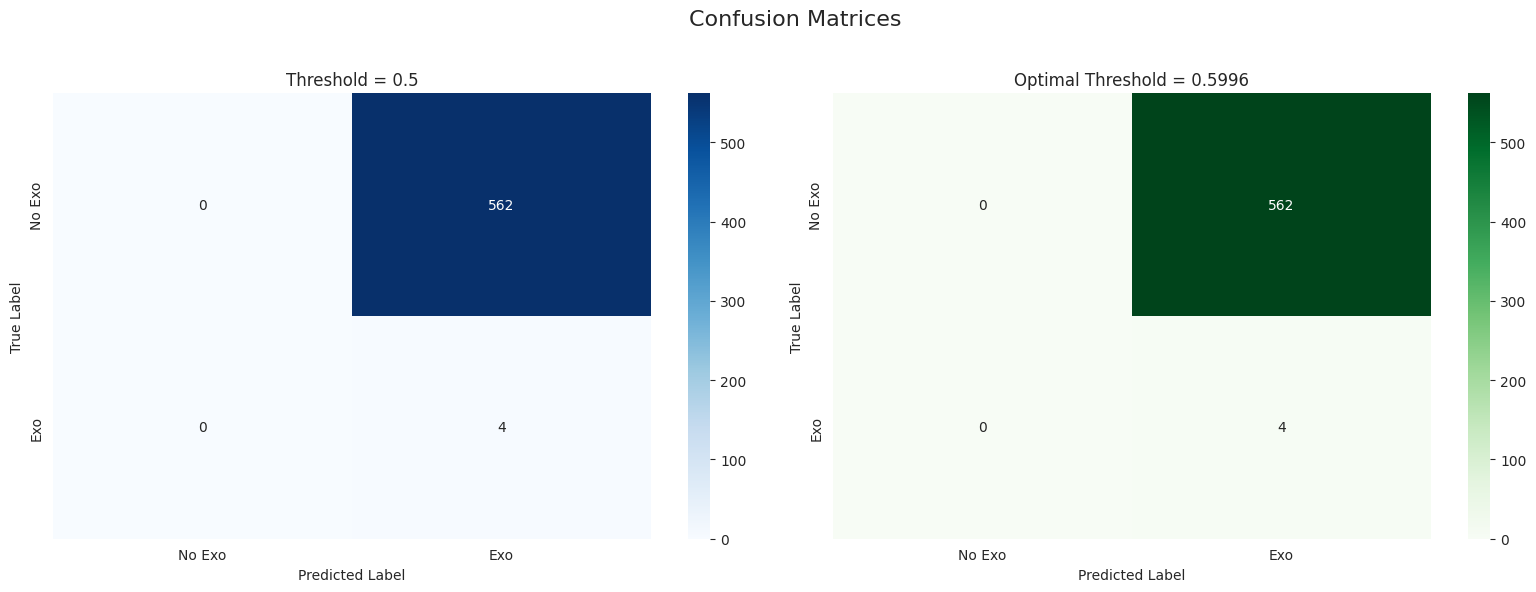

In [34]:
results_df = pd.DataFrame({
    'true_label': y_test,
    'prediction': ensemble_predictions
})

results_df.dropna(inplace=True)

generate_comprehensive_report(results_df['true_label'], results_df['prediction'])